**<center><p style="font-size:40px;">Classification des IRM cérébrales pour la détection de la démence</p></center>**

**Présentation du projet et objectif**


> Ce projet vise à classifier des images d'IRM cérébrales en différentes catégories en fonction de la présence et du degré de démence (un syndrome qui désigne une dégradation progressive des fonctions cognitives, affectant la mémoire et le raisonnement).

> Pour cela on va évaluer et comparer  plusieurs architectures de Deep Learning : CNN / CNN avec Mécanisme d'Attention / Modèles Pré-entraînés (VGG16 et InceptionV3).

**Importation**

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score , recall_score, precision_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Model, Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Lambda, Multiply, GlobalAveragePooling2D , Reshape
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Multiply, GlobalAveragePooling2D, Reshape, Dense, Activation, Concatenate
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from PIL import Image
from tensorflow.keras.layers import Concatenate,Multiply, Activation, Reshape
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model , save_model
from sklearn.model_selection import StratifiedKFold

In [2]:
path = r"C:\Users\skouz\OneDrive\Desktop\atelier\Alzheimer_s Dataset\data"
classes = [ 'NonDemented', 'VeryMildDemented','MildDemented', 'ModerateDemented']

### **Visualisation de la distribution des classes :**

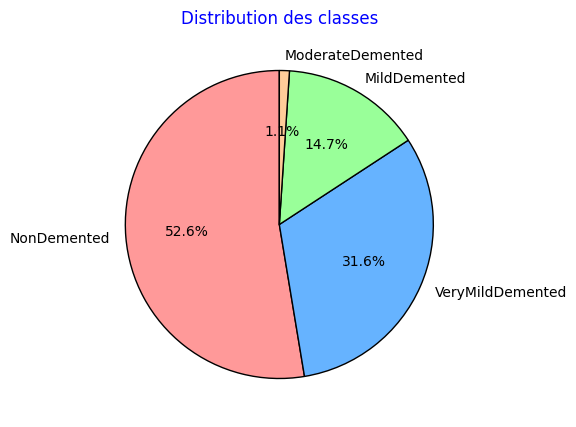

In [3]:
class_counts = {}
for cls in classes:
    class_path = os.path.join(path, cls)
    class_counts[cls] = len(os.listdir(class_path))

plt.figure(figsize=(15, 5))
plt.pie(
    class_counts.values(), 
    labels=class_counts.keys(), 
    autopct='%1.1f%%',  
    startangle=90, 
    colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'],  
    wedgeprops={'edgecolor': 'black'},
     
)
plt.title('Distribution des classes',color='blue')
plt.show()

>  le déséquilibre des classes n'est pas si critique.

### **Affichage d'échantillons d'images :**

In [4]:
#Analyse des dimensions des images :
shapes = {}
for cls in classes:
    sample_path = os.path.join(path, cls, os.listdir(os.path.join(path, cls))[0])
    img = Image.open(sample_path)
    shapes[cls] = img.size
    print(f"{cls}: {shapes[cls]}")

NonDemented: (176, 208)
VeryMildDemented: (176, 208)
MildDemented: (176, 208)
ModerateDemented: (176, 208)


> Toutes les classes ont les mêmes dimensions d’images (176, 208)

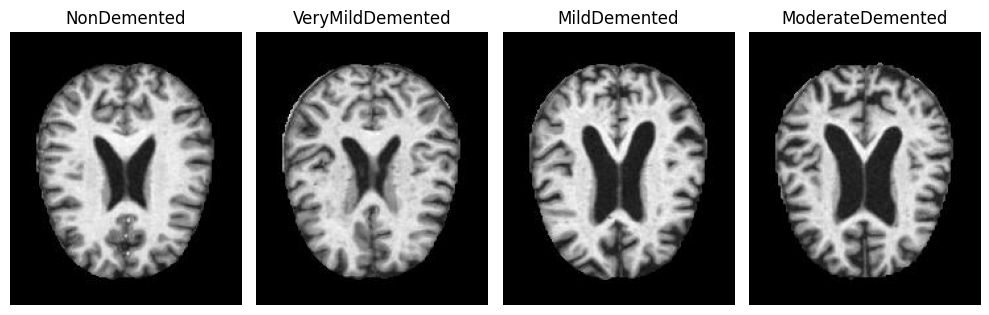

In [5]:
plt.figure(figsize=(10, 5))
for i, cls in enumerate(classes):
    sample_path = os.path.join(path, cls, os.listdir(os.path.join(path, cls))[0])
    img = Image.open(sample_path)
    plt.subplot(1, 4, i+1)
    plt.imshow(img,cmap='gray')
    plt.title(cls)
    plt.axis('off')
plt.tight_layout()
plt.show()

>**Cerveau non dement :** structure cérébrale normale / régions du cerveau intactes et bien définies.

>**Cerveau dement :** une atrophie cérébrale significative / un élargissement notable des ventricules(zones sombres).

### **Préparation des données**

In [6]:
# Load and preprocess images
def load_images(path, classes, img_size=(128, 128)):
    images = []
    labels = []
    
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            # Open image and convert to grayscale if needed
            img = Image.open(img_path).convert('L')
            # Resize image
            img = img.resize(img_size)
            # Convert to numpy array
            img_array = np.array(img)
            # Normalize to 0-1 range : Réduire les valeurs permet
            # d’éviter les problèmes de vanishing ou exploding gradients pendant l’entraînement + Convergence plus rapide
            img_array = img_array / 255.0
            # Add channel dimension
            img_array = np.expand_dims(img_array, axis=-1)
                
            images.append(img_array)
            labels.append(class_idx)
                
    
    return np.array(images), np.array(labels)

In [7]:
# Load all images
X, y = load_images(path, classes)

# Convert labels to integer encoding (0, 1, 2, 3)
label_encoder = LabelEncoder() 
y_encoded = label_encoder.fit_transform(y) 

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)  # On utilise `stratify=y` pour conserver les proportions

### **Création des modèles**

**CNN**

In [8]:
def create_cnn_model(input_shape):
    model = Sequential() # les couches sont empilées linéairement
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape)) # 32 filtres pour détecter les motifs de bas niveau.
    model.add(MaxPooling2D((2, 2))) # réduire la taille spatiale et extraire les caractéristiques principales.
    model.add(Conv2D(64, (3, 3), activation='relu')) # 64 filtres pour capturer plus de motifs complexes.
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu')) #128 filtres pour extraire des caractéristiques de plus haut niveau.
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten()) # Aplatis les sorties 3D pour les rendre compatibles avec les couches denses (fully connected).
    model.add(Dense(128, activation='relu')) 
    model.add(Dropout(0.5)) # Dropout pour réduire le surapprentissage.
    model.add(Dense(4, activation='softmax')) # 4 classes de sortie avec activation softmax pour la classification multi-classes.
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])  
    return model

**CNN with attention** (focus sur les bonnes zones de l’image)

In [9]:
# But: Identifier quels canaux (features) sont les plus importants 
# (Si un canal détecte les bords horizontaux et un autre les tumeurs, il peut donner plus de poids à celui des tumeurs.)
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    gap = GlobalAveragePooling2D()(input_feature)
    dense1 = Dense(channel // ratio, activation='relu')(gap)
    dense2 = Dense(channel, activation='sigmoid')(dense1)
    attention = Reshape((1, 1, channel))(dense2)
    return Multiply()([input_feature, attention])

In [10]:
# But: Identifier où dans l’image il faut porter attention.
# Peut mettre l’accent sur une zone suspecte dans une IRM.
def spatial_attention(input_feature):
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    return Multiply()([input_feature, attention])

In [11]:
def create_cnn_with_dual_attention(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Base CNN
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Apply Channel Attention
    x = channel_attention(x)
    
    # Apply Spatial Attention
    x = spatial_attention(x)
    
    # Classifier Head
    x = Flatten()(x) # transform 3D tensor to 1D tensor
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs, name='CNN_Dual_Attention')
    model.compile(optimizer='adam', 
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

**VGG pré-entraîné**

![VGG16](images/VGG16.png)

In [12]:
def create_vgg_model(input_shape, num_classes):
    # convert input shape to 3 channels (VGG16 a besoin de 3 canaux)
    input_tensor = Input(shape=input_shape)
    x = Concatenate()([input_tensor, input_tensor, input_tensor]) 
    
    # Load VGG16
    base_model = VGG16(weights='imagenet', # charger les poids pré-entraînés sur ImageNet
                      include_top=False, # sans la couche de classification finale
                      input_tensor=x)
    
    # Freeze base model
    base_model.trainable = False # ne pas entraîner les poids de VGG16 : réduire le surapprentissage / accélérer l'entraînement 
    
    # Add custom head
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=predictions)
    model.compile(optimizer=Adam(0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

**GoogleNet (InceptionV3) pré-entraîné**

![InceptionV3](images/inception_v3.png)

> applique plusieurs convolutions en parallèle et concatène leurs résultats.

In [13]:
def create_inception_model(input_shape, num_classes):
    # Input layer
    input_tensor = Input(shape=input_shape)

    # Convert grayscale to RGB
    x = Lambda(lambda x: tf.repeat(x, 3, axis=-1))(input_tensor)
    
    
    # Load InceptionV3 with pre-trained weights
    base_model = InceptionV3(weights='imagenet',
                           include_top=False,
                           input_tensor=x)
    
    # Freeze base model
    base_model.trainable = False
    
    # Add custom head
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=predictions)
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

### **Entraînement des modèles**

In [14]:
def train_and_evaluate(model, X_train, y_train, epochs=10, batch_size=32): # batch size: nombre d’échantillons traités en parallèle.
    # Historique des métriques
    history = {
        'train_acc': [],
        'val_acc': [],
        'train_loss': [],
        'val_loss': [],
    }
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        
        # Division train/val (stratifiée)
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train, y_train, 
            test_size=0.2, 
            random_state=epoch, # pour avoir des splits différents à chaque époque
            stratify=y_train
        )
        
        # Entraînement
        training = model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=1, # on entraîne pour une époque à la fois
            batch_size=batch_size,
            verbose=1 # afficher les détails de l'entraînement
        )
        
        # Sauvegarde des métriques de base
        history['train_acc'].append(training.history['accuracy'][0])
        history['val_acc'].append(training.history['val_accuracy'][0])
        history['train_loss'].append(training.history['loss'][0])
        history['val_loss'].append(training.history['val_loss'][0])
        

    # Visualisation
    plt.figure(figsize=(15, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), history['train_acc'], label='Train Accuracy')
    plt.plot(range(1, epochs+1), history['val_acc'], label='Validation Accuracy')
    plt.title(f'Accuracy - {model.name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), history['train_loss'], label='Train Loss')
    plt.plot(range(1, epochs+1), history['val_loss'], label='Validation Loss')
    plt.title(f'Loss - {model.name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return

**CNN**

Training CNN model...


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.4976 - loss: 1.1207 - val_accuracy: 0.5334 - val_loss: 0.9756

Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.5404 - loss: 0.9420 - val_accuracy: 0.6249 - val_loss: 0.8650

Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.6217 - loss: 0.8523 - val_accuracy: 0.6845 - val_loss: 0.7324

Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.6353 - loss: 0.7853 - val_accuracy: 0.7461 - val_loss: 0.6278

Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.7105 - loss: 0.6527 - val_accuracy: 0.7708 - val_loss: 0.5309

Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.7643 - loss: 0.5380 - val_accuracy: 0.8530 - val_loss: 0.3956

Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.8146 - loss: 0.4415 - val_accuracy: 0.9054 - val_loss: 0.2812

Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.8546 - loss: 0

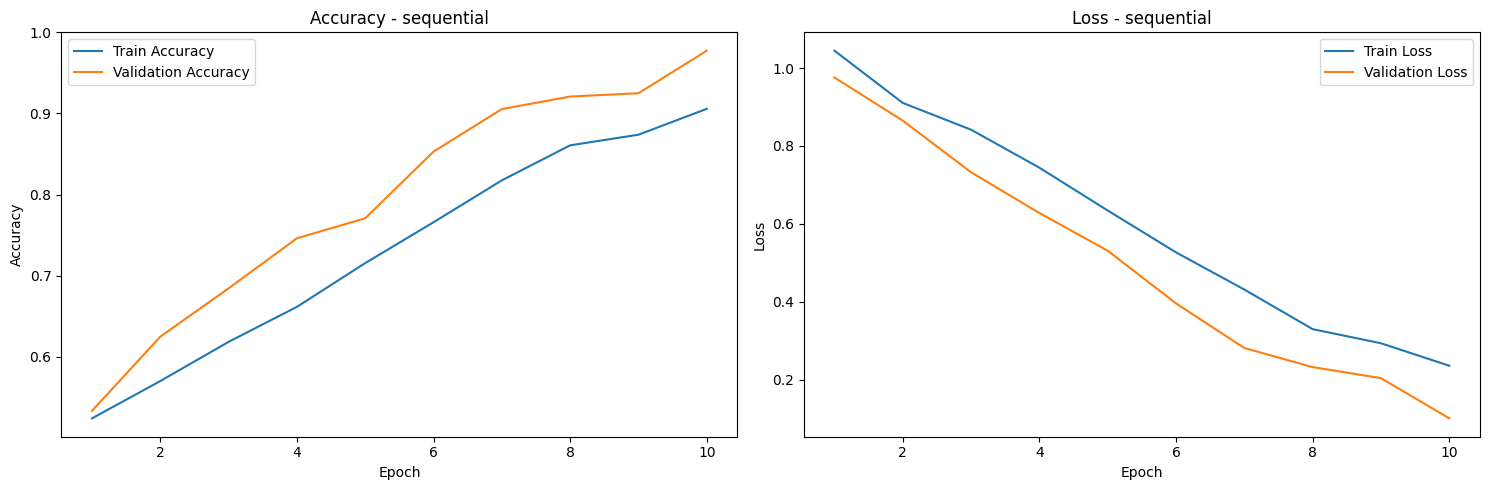

In [17]:
input_shape = X_train[0].shape
print("Training CNN model...")
cnn_model = create_cnn_model(input_shape)
cnn_metrics = train_and_evaluate(cnn_model, X_train, y_train, epochs=10)

> Le CNN apprend correctement, converge bien, et généralise efficacement sans surapprentissage

**CNN with both Spatial and Channel Attention**

Training CNN_att model...


Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.4967 - loss: 1.0611 - val_accuracy: 0.5344 - val_loss: 0.9172

Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.5912 - loss: 0.8717 - val_accuracy: 0.6578 - val_loss: 0.7961

Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - accuracy: 0.6707 - loss: 0.7684 - val_accuracy: 0.6835 - val_loss: 0.7125

Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.7495 - loss: 0.5879 - val_accuracy: 0.8129 - val_loss: 0.4821

Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - accuracy: 0.8591 - loss: 0.3700 - val_accuracy: 0.9147 - val_loss: 0.2395

Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.9289 - loss: 0.1930 - val_accuracy: 0.9651 - val_loss: 0.0975

Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.9786 - loss: 0.0771 - val_accuracy: 0.9805 - val_loss: 0.0804

Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 118m

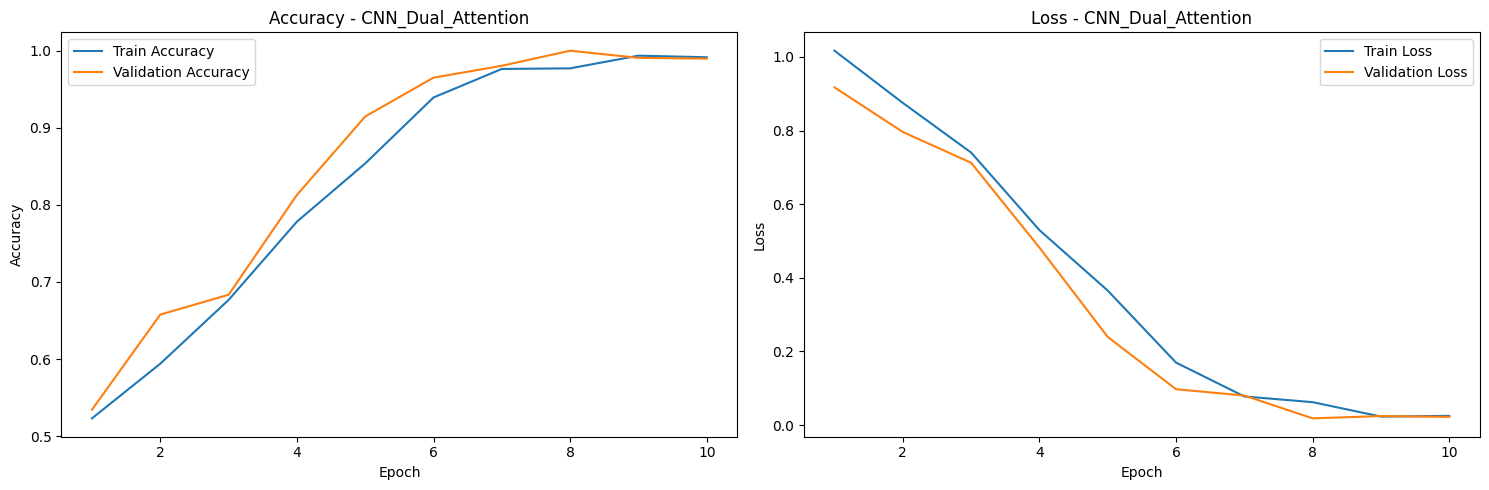

In [18]:
# Get input shape
input_shape = X_train[0].shape
# Create and train CNN model
print("Training CNN_att model...")
cnn_att_model = create_cnn_with_dual_attention(input_shape, len(classes))
cnn_att_metrics = train_and_evaluate(cnn_att_model, X_train, y_train, epochs=10)

> Le CNN avec att apprend correctement, converge bien, et généralise efficacement sans surapprentissage

**VGG16**


Training VGG16 model...

Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 81s 655ms/step - accuracy: 0.4941 - loss: 1.4427 - val_accuracy: 0.5653 - val_loss: 0.9131

Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 80s 659ms/step - accuracy: 0.5510 - loss: 0.9590 - val_accuracy: 0.6084 - val_loss: 0.8846

Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 80s 660ms/step - accuracy: 0.5720 - loss: 0.8971 - val_accuracy: 0.5704 - val_loss: 0.8570

Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 82s 674ms/step - accuracy: 0.5738 - loss: 0.9022 - val_accuracy: 0.5982 - val_loss: 0.8174

Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 80s 653ms/step - accuracy: 0.5699 - loss: 0.8956 - val_accuracy: 0.6002 - val_loss: 0.8264

Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 81s 669ms/step - accuracy: 0.5848 - loss: 0.8859 - val_accuracy: 0.6393 - val_loss: 0.7905

Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 83s 684ms/step - accuracy: 0.6003 - loss: 0.8506 - val_accuracy: 0.6393 - val_loss: 0.7544

Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 82s 669ms/

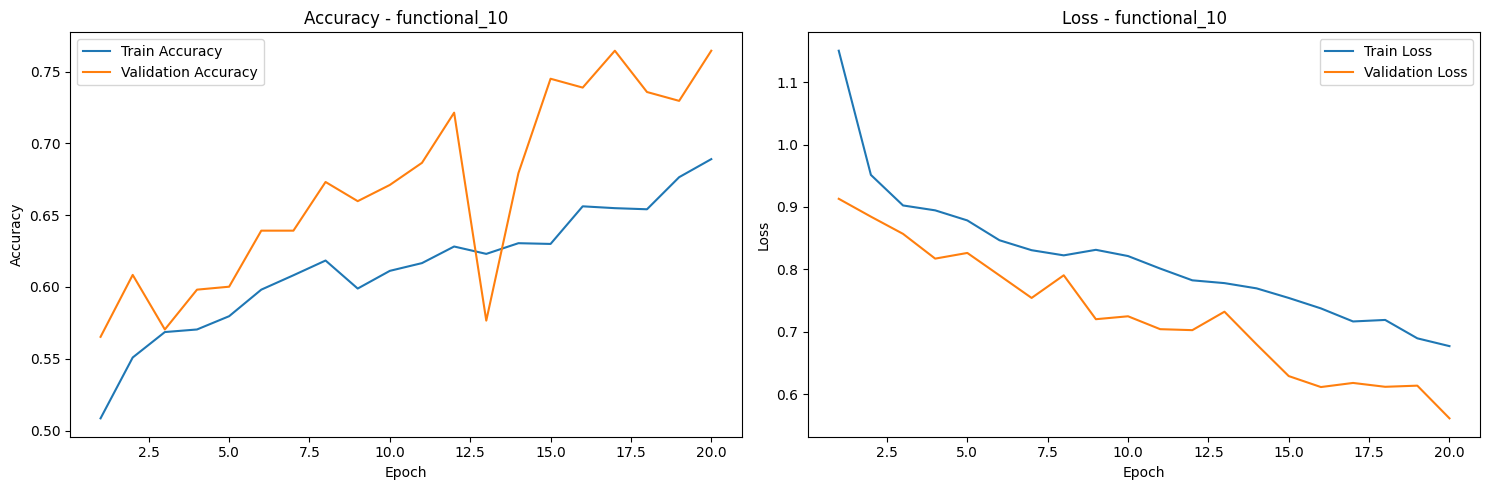

In [19]:
print("\nTraining VGG16 model...")
vgg_model = create_vgg_model(input_shape, len(classes))
vgg_metrics = train_and_evaluate(vgg_model, X_train, y_train, epochs=20)

> Le modèle ne s'entraîne pas correctement 

**InceptionV3**


Training InceptionV3 model...

Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 163ms/step - accuracy: 0.4402 - loss: 7.5704 - val_accuracy: 0.5427 - val_loss: 0.9048

Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 0.5117 - loss: 0.9990 - val_accuracy: 0.5591 - val_loss: 0.8842

Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 0.5525 - loss: 0.9423 - val_accuracy: 0.5653 - val_loss: 0.8481

Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 0.5608 - loss: 0.9344 - val_accuracy: 0.5786 - val_loss: 0.8578

Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.5498 - loss: 0.9190 - val_accuracy: 0.5786 - val_loss: 0.8354

Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 0.5645 - loss: 0.9178 - val_accuracy: 0.5951 - val_loss: 0.8798

Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 0.5596 - loss: 0.9363 - val_accuracy: 0.5930 - val_loss: 0.8404

Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 

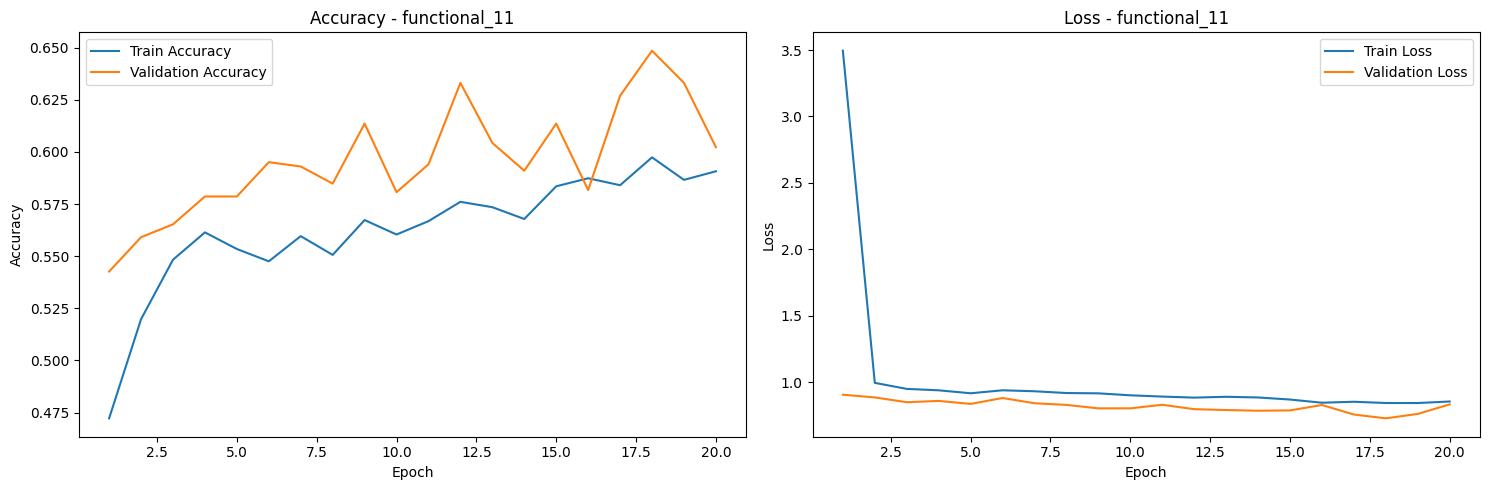

In [20]:
print("\nTraining InceptionV3 model...")
inception_model = create_inception_model(input_shape, len(classes))
inception_model._name = "InceptionV3"
inception_metrics = train_and_evaluate(inception_model, X_train, y_train, epochs=20)

> Le modèle ne s'entraîne pas correctement 

### **Test et comparaison**

In [ ]:
def evaluate_on_test(model, X_test, y_test):
    y_test_pred_proba = model.predict(X_test, verbose=0)     
    y_test_pred = np.argmax(y_test_pred_proba, axis=1)

    # Métriques globales
    metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision_weighted': precision_score(y_test, y_test_pred, average='weighted'),
        'recall_weighted': recall_score(y_test, y_test_pred, average='weighted'),
        'f1_weighted': f1_score(y_test, y_test_pred, average='weighted'),
        'auc_ovr': roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr')
    }

    # Métriques par classe
    report = classification_report(y_test, y_test_pred, target_names=classes, output_dict=True)
    for label in classes:
        metrics[f'precision_{label}'] = report[label]['precision']
        metrics[f'recall_{label}'] = report[label]['recall']
        metrics[f'f1_{label}'] = report[label]['f1-score']
    
    return metrics

In [29]:
test_results = []

models = {
    'CNN': cnn_model,
    'CNN_att': cnn_att_model,
    'VGG16': vgg_model,
    'InceptionV3': inception_model
}

for model_name, model in models.items():
    metrics = evaluate_on_test(model, X_test, y_test)
    metrics['model'] = model_name
    test_results.append(metrics)

# Création du DataFrame
test_results_df = pd.DataFrame(test_results)

# Affichage
print("\nTest Results (global + par classe) :")
print(test_results_df.set_index('model').T)


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()


Test Results (global + par classe) :
model                            CNN   CNN_att     VGG16  InceptionV3
accuracy                    0.925226  0.960559  0.737058     0.585045
precision_weighted          0.925045  0.961710  0.756700     0.572893
recall_weighted             0.925226  0.960559  0.737058     0.585045
f1_weighted                 0.924620  0.960782  0.738967     0.551749
auc_ovr                     0.989710  0.995482  0.928724     0.828269
precision_NonDemented       0.934750  0.985460  0.859745     0.835073
recall_NonDemented          0.962500  0.953125  0.737500     0.625000
f1_NonDemented              0.948422  0.969023  0.793944     0.714924
precision_VeryMildDemented  0.902703  0.918719  0.716535     0.422764
recall_VeryMildDemented     0.867532  0.968831  0.709091     0.810390
f1_VeryMildDemented         0.884768  0.943110  0.712794     0.555654
precision_MildDemented      0.932961  0.966480  0.529617     0.000000
recall_MildDemented         0.932961  0.966480  0.84

c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

> Le modèle CNN avec attention est clairement supérieur.

> Le modèle CNN reste une bonne alternative.

> Les modèles pré-entraînés VGG16 et InceptionV3 n’ont pas su bien s’adapter à la spécificité des données.

In [ ]:
test_results = []

models = {
    'CNN': cnn_model,
    'CNN_att': cnn_att_model,
    'VGG16': vgg_model,
    'InceptionV3': inception_model
}

for model_name, model in models.items():
    metrics = evaluate_on_test(model, X_test, y_test)
    metrics['model'] = model_name
    test_results.append(metrics)

# Création du DataFrame
test_results_df = pd.DataFrame(test_results)

# Affichage
print("\nTest Results (global + par classe) :")
print(test_results_df.set_index('model').T)

**Matrices de Confusion Comparatives**

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


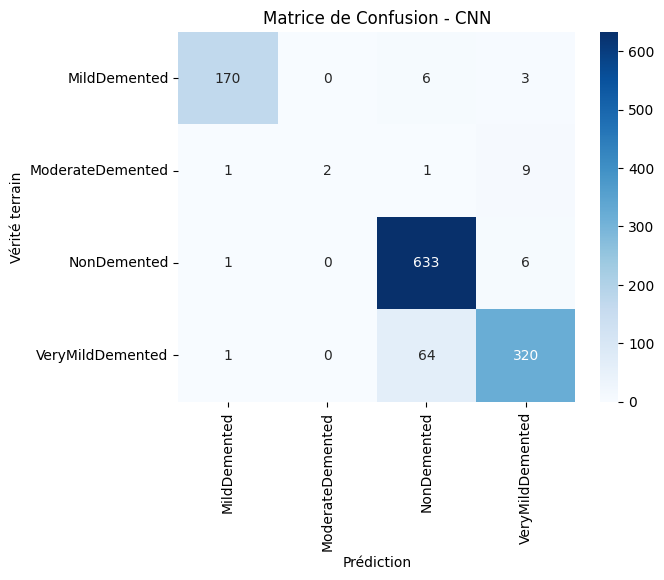

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


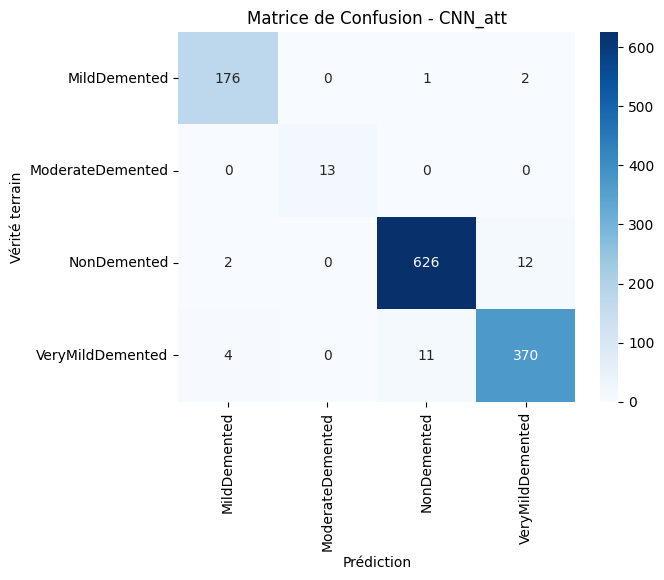

39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 525ms/step


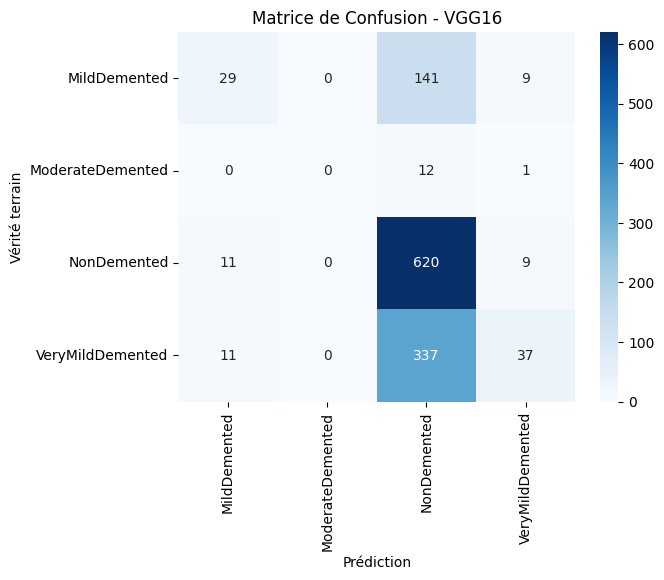

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step


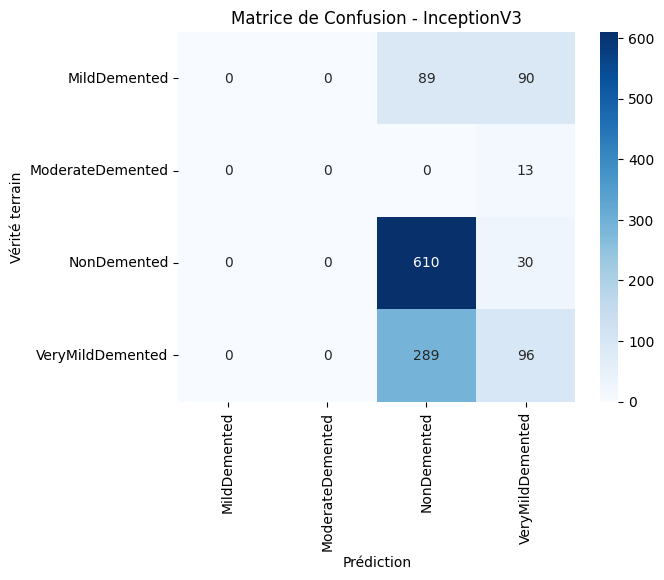

In [ ]:
for model_name, model in models.items():
    y_pred = np.argmax(model.predict(X_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, 
                yticklabels=classes)
    plt.title(f'Matrice de Confusion - {model_name}')
    plt.ylabel('Vérité terrain')
    plt.xlabel('Prédiction')
    plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 514ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step


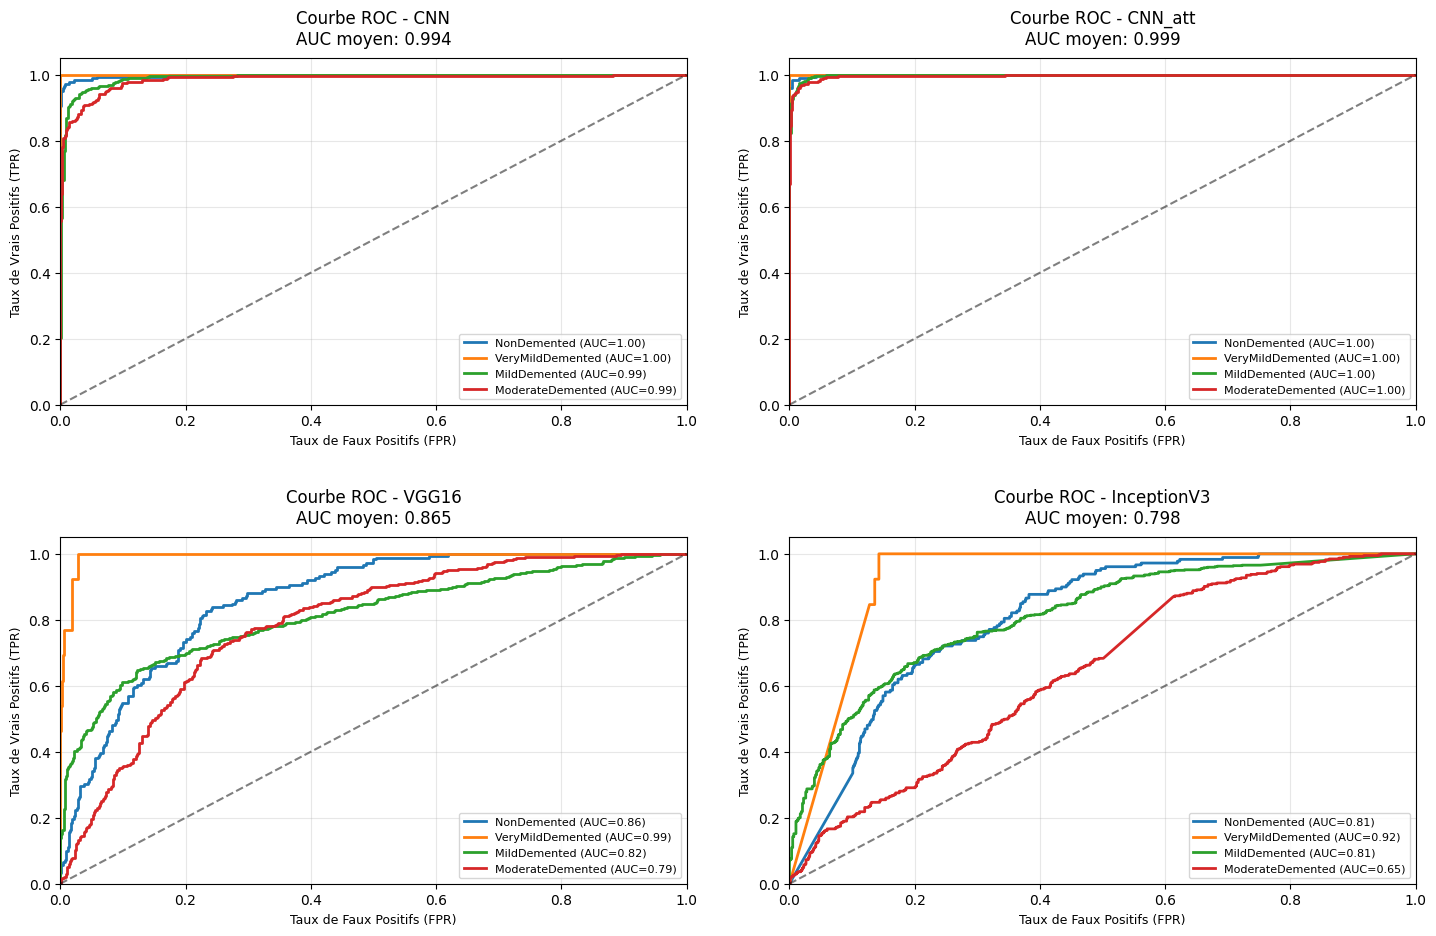

In [ ]:
plt.figure(figsize=(15, 10))

# Noms des classes (à adapter selon votre cas)
class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']  
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Couleurs distinctes

for idx, (model_name, model) in enumerate(models.items(), 1):
    y_score = model.predict(X_test)
    
    plt.subplot(2, 2, idx)
    
    # Calcul de l'AUC moyen
    auc_scores = []
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        plt.plot(fpr, tpr, color=colors[i], lw=2,
                label=f'{class_names[i]} (AUC={roc_auc:.2f})')
    
    mean_auc = np.mean(auc_scores)
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=9)
    plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=9)
    plt.title(f'Courbe ROC - {model_name}\nAUC moyen: {mean_auc:.3f}', fontsize=12, pad=10)
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True, alpha=0.3)

plt.tight_layout(pad=3.0)
plt.show()

### **Sauveguarde et importe du modele**

In [38]:
# Save models
save_model(cnn_model, 'cnn_model.h5')
save_model(cnn_att_model, 'cnn_att_model.h5')
save_model(vgg_model, 'vgg_model.h5')
save_model(inception_model, 'inception_model.h5')

In [47]:
# Charger le modèle
model_loaded = load_model("cnn_model.h5") 

In [56]:
def predict_with_random_image(model, dataset_path, class_names):
    """
    Version corrigée qui s'adapte automatiquement à la shape d'entrée du modèle
    """
    # Sélectionner une image aléatoire
    image_path = select_random_image(dataset_path)
    
    # Trouver la classe réelle
    true_class = os.path.basename(os.path.dirname(image_path))
    
    # Déterminer la taille d'entrée attendue par le modèle
    if len(model.input_shape) == 4:
        img_size = model.input_shape[1:3]  # (height, width)
        target_channels = model.input_shape[3]
    else:
        img_size = model.input_shape[1:]  # Cas particulier
        target_channels = 1
    
    # Charger et prétraiter l'image
    img = Image.open(image_path).convert('L').resize(img_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=-1)  # (h, w, 1)
    
    # Adapter les canaux si nécessaire
    if target_channels == 3:
        img_array = np.repeat(img_array, 3, axis=-1)  # (h, w, 3)
    elif target_channels == 1:
        pass  # Déjà au bon format
    else:
        raise ValueError(f"Format de canal non supporté: {target_channels}")
    
    # Ajouter dimension batch (1, h, w, c)
    img_array = np.expand_dims(img_array, axis=0)
    
    try:
        # Faire la prédiction
        pred_proba = model.predict(img_array)
        pred_class_idx = np.argmax(pred_proba)
        pred_class = class_names[pred_class_idx]
        confidence = pred_proba[0][pred_class_idx]
        
        # Afficher les résultats
        plt.figure(figsize=(12, 5))
        
        # Image originale
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Image: {os.path.basename(image_path)}\nClasse réelle: {true_class}")
        plt.axis('off')
        
        # Probabilités
        plt.subplot(1, 2, 2)
        bars = plt.barh(class_names, pred_proba[0])
        bars[pred_class_idx].set_color('red')
        plt.title('Probabilités de prédiction')
        plt.xlabel('Confiance')
        plt.xlim([0, 1])
        
        plt.suptitle(f"Prédiction: {pred_class} (Confiance: {confidence:.2%})")
        plt.tight_layout()
        plt.show()
        
        print("\nDétails de prédiction:")
        for i, prob in enumerate(pred_proba[0]):
            print(f"{class_names[i]}: {prob:.2%}")
        
        return {
            'image_path': image_path,
            'true_class': true_class,
            'predicted_class': pred_class,
            'confidence': confidence,
            'probabilities': pred_proba[0].tolist()
        }
        
    except Exception as e:
        print(f"Erreur lors de la prédiction: {str(e)}")
        print(f"Shape de l'image fournie: {img_array.shape}")
        print(f"Shape attendue par le modèle: {model.input_shape}")
        return None

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


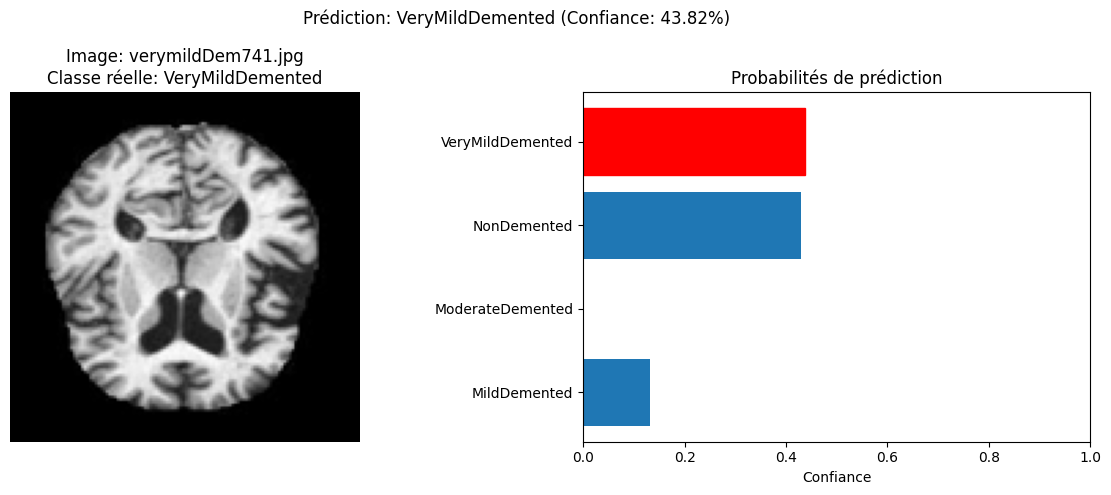


Détails de prédiction:
MildDemented: 13.12%
ModerateDemented: 0.03%
NonDemented: 43.03%
VeryMildDemented: 43.82%


In [57]:
# Faire une prédiction
result = predict_with_random_image(model, path, classes)